Data: Combined with added features , Shades and Radiation. <br>
Split: Train, Validate, Test

# 1. Import and Load

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# parameters search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# models
from sklearn.ensemble import RandomForestRegressor

# explain
from sklearn.tree import export_graphviz

from datetime import datetime
import os
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
# import shap

In [75]:
Bldg = pd.read_csv("/content/drive/Shareddrives/Microclimate-Building Energy/Data/microclimate_model/Combined/summer_limited2.csv")
Bldg = Bldg.drop(columns = ['Unnamed: 0','CHWTON'])


In [76]:
Tree_X = pd.read_csv("/content/drive/Shareddrives/Microclimate-Building Energy/Data/microclimate_model/Scenarios/June_9_trees.csv")
Tree_X = Tree_X.drop(columns = ['Unnamed: 0','CHWTON','CHWTON/SQFT' ])


# 2. EDA

## 2.1 Compare Temperature

In [51]:
J_9 = Bldg[(Bldg['Month'] == 6) & (Bldg['Day'] == 9)]


temperature = pd.DataFrame()
temperature['bldgname'] = J_9['bldgname']
temperature['Base'] = J_9['Air Temp']
temperature = temperature.reset_index()
temperature['Tree'] = Tree_X['Air Temp']

temperature.drop(columns = ['index'], inplace = True)

temperature


bldgname       Base       Tree
0    Noble Library  29.578951  29.507257
1    Noble Library  29.068746  29.047179
2    Noble Library  28.741506  28.767364
3    Noble Library  28.550811  28.576198
4    Noble Library  28.346988  28.372186
..             ...        ...        ...
635    Biodesign B  38.580270  38.546036
636    Biodesign B  38.333556  38.309903
637    Biodesign B  38.067908  38.041853
638    Biodesign B  37.871024  37.850644
639    Biodesign B  37.654008  37.636041

[640 rows x 3 columns]

In [54]:
temperature[temperature['bldgname'] == 'Noble Library']['Tree']

0     29.507257
1     29.047179
2     28.767364
3     28.576198
4     28.372186
        ...    
59    38.527226
60    38.326451
61    38.080587
62    37.902603
63    37.707359
Name: Tree, Length: 64, dtype: float64

64
64
64
64
64
64
64
64
64


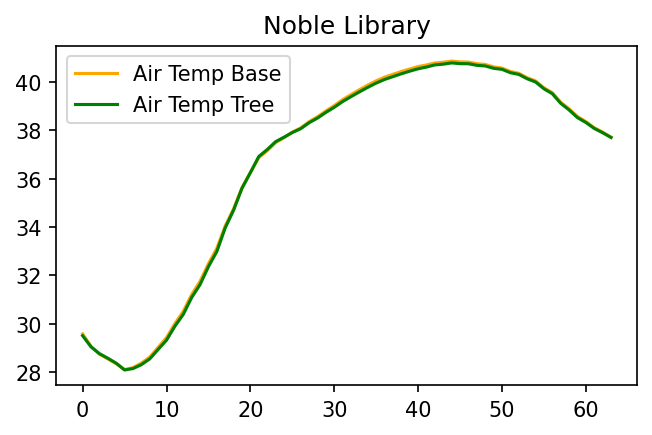

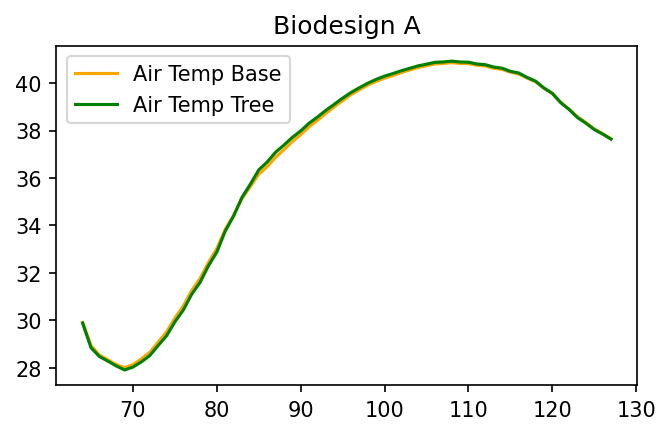

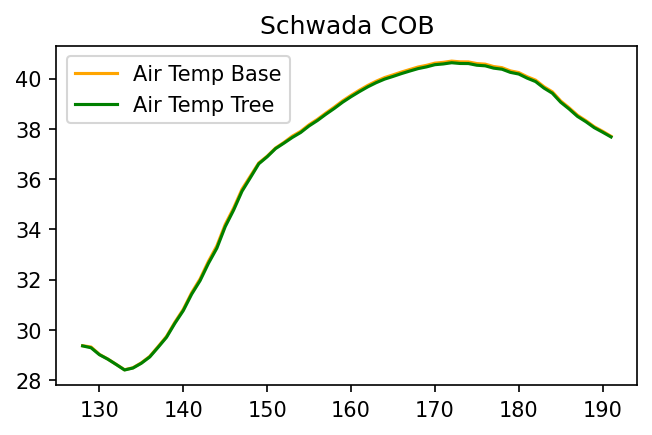

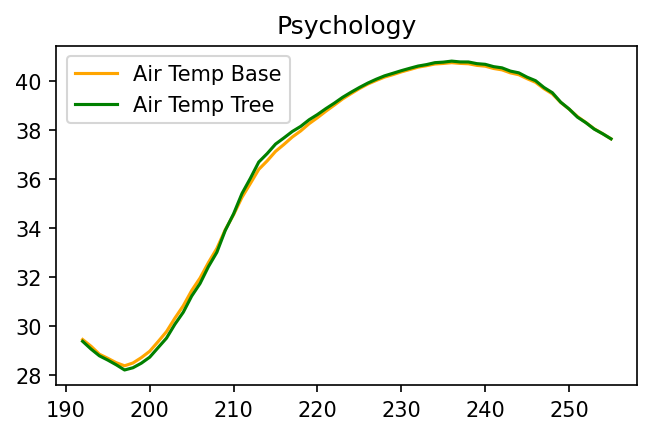

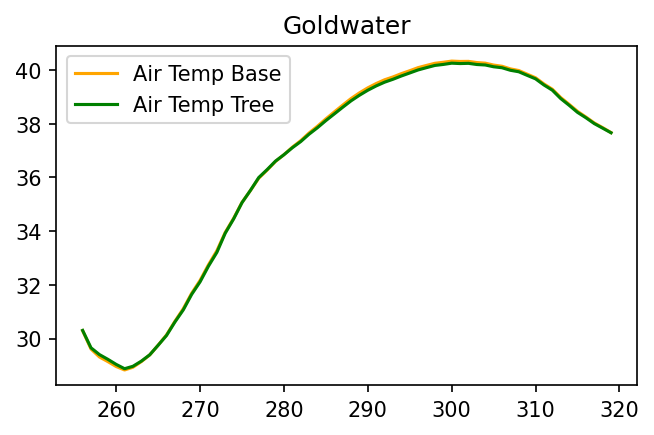

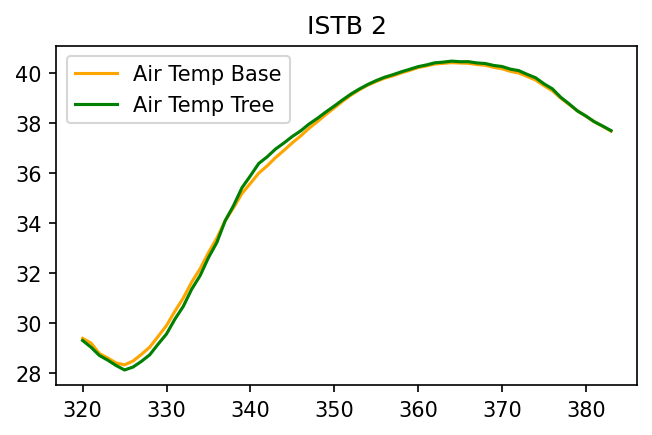

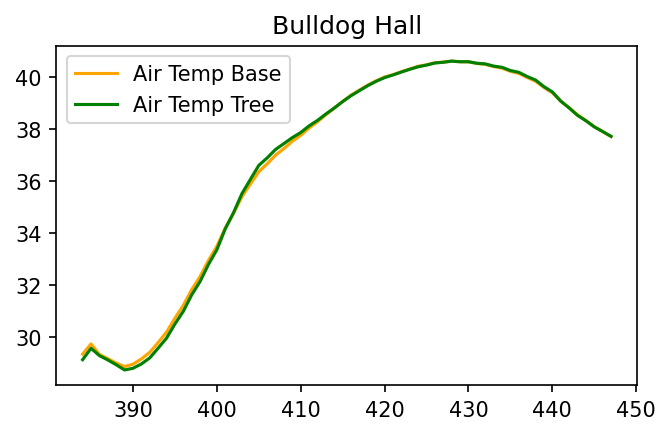

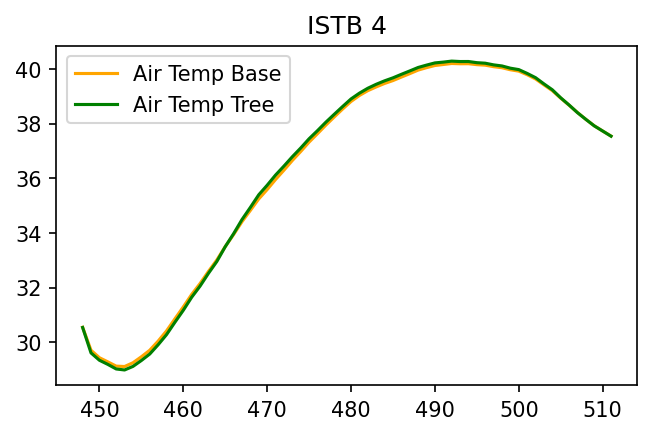

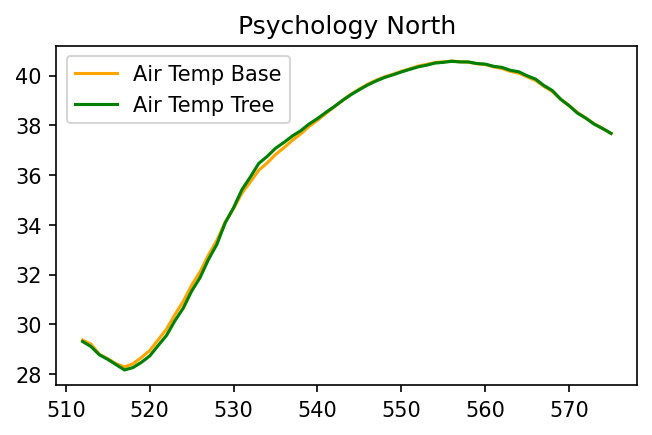

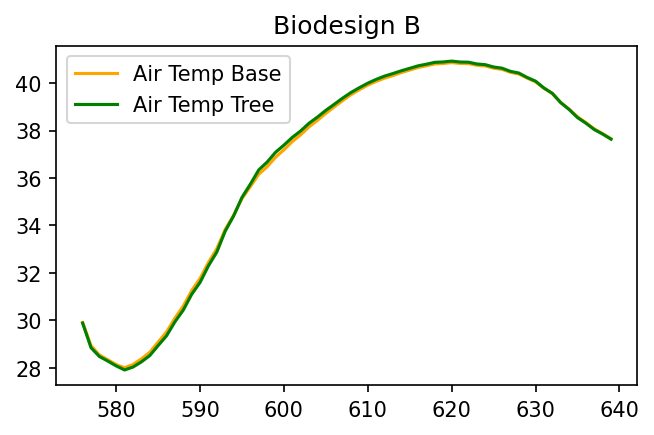

In [53]:
# # 1. get label for plot
BldgName = list(Bldg.bldgname.unique())
BldgnameTest = BldgName 
BldgnameTest.pop(1) # remove the second building (data doesnt exists)


# 2. get position for plots
# print the number of elements per building
for i in range(len(BldgnameTest)-1):
    print((temperature.bldgname == BldgName[i]).sum())
    
# # create array accordingly
position = np.linspace(0, 640, num=11).tolist()

# remove last index
position.pop()


for i in range(len(BldgnameTest)):
    # from matplotlib.pyplot import figure
    figure(figsize=(5, 3), dpi=150)
    # plt.xticks( position, BldgnameTest )
    plt.plot(temperature[temperature['bldgname'] == BldgnameTest[i]]['Base'], label = 'Air Temp Base', color="orange")
    plt.plot(temperature[temperature['bldgname'] == BldgnameTest[i]]['Tree'], label = 'Air Temp Tree', color="green")
    plt.legend()
    plt.title(BldgnameTest[i])

## 2.2 Boxplots

In [27]:
# # 1. Create List of building names so we can extract the name easily 
# BldgName = list(Bldg.bldgname.unique())

# # 2. Create list of building df to do time series plot of CHWTON
# BldgList = []

# for i in range(len(BldgName)):
#     bldg_single = Bldg[Bldg['bldgname'] == BldgName[i]]
#     bldg_single = bldg_single[['bldgname', 'Date_Time','CHWTON/SQFT','Hour']]
#     bldg_single[BldgName[i]] = bldg_single['CHWTON/SQFT']
#     bldg_single = bldg_single.drop(columns = ['bldgname'])
#     BldgList.append(bldg_single)
    

# #3. Create CHWTON boxplots for all buildings #
# def createBoxPlot(df, columnName, BldgName):
#     row_size = 6
#     column_size = 2
#     fig, ax = plt.subplots(row_size, column_size, figsize = (15,40))

#     i = 0
#     # 1. loop through the 11 buildings
#     while i < (len(BldgName)):
#         # 2. Create row (6)
#         for row in range(row_size):
#             #4. Create column 2
#             for col in range(column_size):
#                 if i < (len(BldgName)):
                    
#                     # create boxplot of this df
#                     df[i].boxplot(by='Hour',
#                                     column=[columnName],
#                                     grid = False,
#                                     figsize = (4,4),
#                                     ax = ax[row,col] )
#                     ax[row,col].title.set_text(BldgName[i])
#                     i += 1

#     fig.suptitle(columnName + ' Boxplot by Hour')
#     plt.show()
    
# createBoxPlot(BldgList, 'CHWTON/SQFT', BldgName)

## 2.3 Feature engineering Temp and Humidity

In [77]:
# Get Air Temp X Abs Hum
Bldg = Bldg.drop(columns = ['Rel Hum'])

Bldg['AirTempXAbsHum'] = Bldg['Air Temp'] * Bldg['Abs Hum']
Bldg['AirTempSq'] = Bldg['Air Temp'] * Bldg['Air Temp']
Bldg['AbsHumSq'] = Bldg['Abs Hum'] * Bldg['Abs Hum']
Bldg = Bldg.drop(columns = ['Air Temp', 'Abs Hum'])

# Remove August and September data
Bldg = Bldg[~((Bldg['Month'] == 8) | (Bldg['Month'] == 9))]


# Get Air Temp X Abs Hum
Tree_X = Tree_X.drop(columns = ['Rel Hum'])

Tree_X['AirTempXAbsHum'] = Tree_X['Air Temp'] * Tree_X['Abs Hum']
Tree_X['AirTempSq'] = Tree_X['Air Temp'] * Tree_X['Air Temp']
Tree_X['AbsHumSq'] = Tree_X['Abs Hum'] * Tree_X['Abs Hum']
Tree_X = Tree_X.drop(columns = ['Air Temp', 'Abs Hum'])

# Remove August and September data
Tree_X = Tree_X[~((Tree_X['Month'] == 8) | (Tree_X['Month'] == 9))]

## 2.4 Time Series Plot

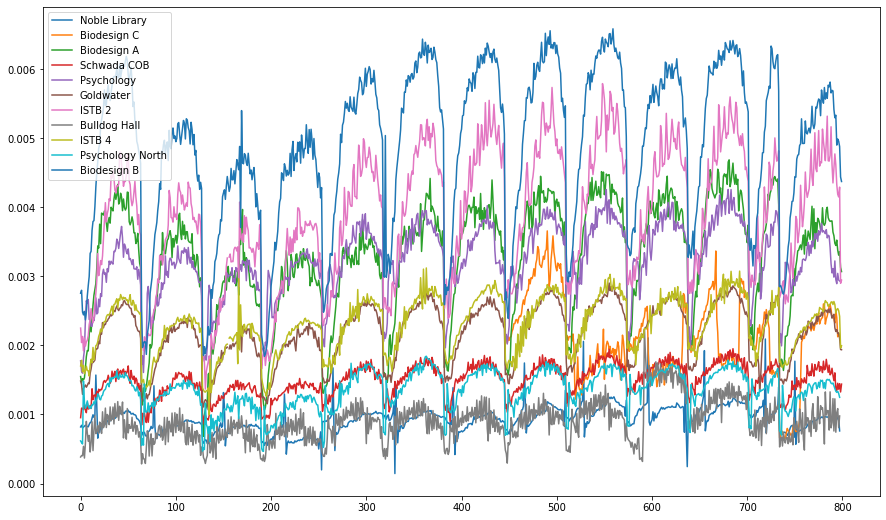

In [56]:
# 1. Create List of building names so we can extract the name easily 
BldgName = list(Bldg.bldgname.unique())

# 2. Create list of building df to do time series plot of CHWTON
BldgList = []

for i in range(len(BldgName)):
    bldg_single = Bldg[Bldg['bldgname'] == BldgName[i]]
    bldg_single = bldg_single[['bldgname', 'Date_Time','CHWTON/SQFT']]
    bldg_single[BldgName[i]] = bldg_single['CHWTON/SQFT']
    bldg_single = bldg_single.drop(columns = ['bldgname', 'CHWTON/SQFT'])
    BldgList.append(bldg_single)
    
Bldg = Bldg.drop(columns = ['Date_Time'])

from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date_Time'],
                                            how='outer'), BldgList)


# Print CHWTON/SQFT for all buildings and all timestamps in data
ax = df_merged['Noble Library'].plot(figsize = (15,9))
legendlabels = []
legendlabels.append('Noble Library')

for i in range(2, 12):
    bldgName = df_merged.columns[i]
    df_merged[bldgName].plot(ax=ax)
    legendlabels.append(df_merged.columns[i])
    
ax.legend(labels = legendlabels)

## 2.5 Corr. Matrix


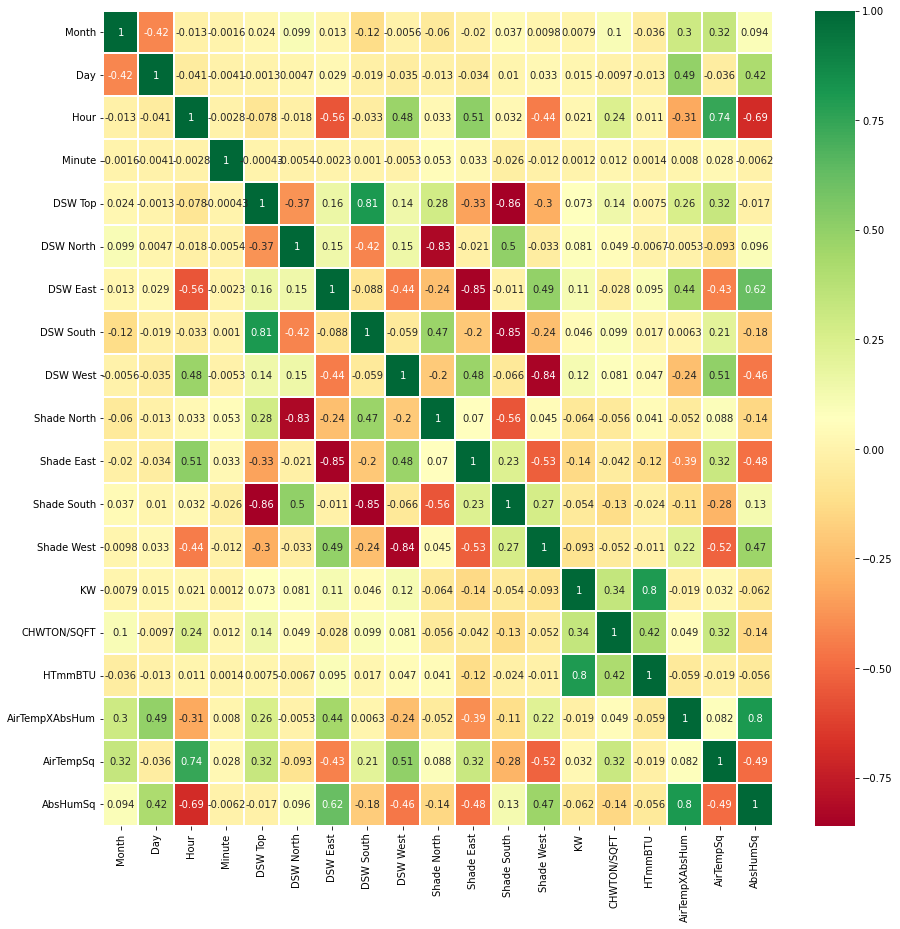

In [57]:
corrMatrix = Bldg.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corrMatrix, cmap='RdYlGn', annot = True, linewidths = 1)
plt.show()

# 3. One Hot Encoding

In [78]:
# Integer Encode
Bldg = pd.get_dummies(Bldg, drop_first = True)
Bldg.columns

Index(['Month', 'Day', 'Hour', 'Minute', 'DSW Top', 'DSW North', 'DSW East',
       'DSW South', 'DSW West', 'Shade North',
       ...
       'Date_Time_2018-07-01 18:30:00', 'Date_Time_2018-07-01 18:45:00',
       'Date_Time_2018-07-01 19:00:00', 'Date_Time_2018-07-01 19:15:00',
       'Date_Time_2018-07-01 19:30:00', 'Date_Time_2018-07-01 19:45:00',
       'Date_Time_2018-07-01 20:00:00', 'Date_Time_2018-07-01 20:15:00',
       'Date_Time_2018-07-01 20:30:00', 'Date_Time_2018-07-01 20:45:00'],
      dtype='object', length=828)

# 4. Modelling set up

## 4.1 Pick desired date for Test

Month available:<br>
May: 10, 16, 23, 28<br>
June: 7, 8, 9, 20, 21, 25, 26, 27<br>
July: 1<br>

Not Usable:<br>
August: 1, 3, 27<br>
September: 11, 29<br>

June 9 tree<br>



In [79]:
# 1. Get user to pick the day
day = (input("Pick month and day <mm dd> or 00 00 for tree: "))
m,d = day.split(" ")
m = int(m)
d= int(d)

# 2. If its tree:
if (m == 0) & (d == 0):
    print("you picked tree scenario")
else:
    # if not tree and not available:
    while (len(Bldg[(Bldg['Month'] == m) & (Bldg['Day'] == d)]) == 0):
        day = (input("Date unavailable, pick month and day <mm dd>: "))
        m,d = day.split(" ")
        m = int(m)
        d = int(d)
    

print("You picked month: ", m, ", day: ",d)

Pick month and day <mm dd> or 00 00 for tree: 06 09
You picked month:  6 , day:  9


In [ ]:
# Check this test data
# Bldg[(Bldg['Month'] == m) & (Bldg['Day'] == d)]

In [80]:
# Create test data frame
if(m == 0) & (d == 0):
    Test_df = Tree_df
else:
    Test_df = Bldg[(Bldg['Month'] == m) & (Bldg['Day'] == d)]
    Test_df.reset_index(drop = True, inplace = True)
    Test_df

    # Remove Test From Bldg df 
Bldg = Bldg[~((Bldg['Month'] == m) & (Bldg['Day'] == d))]


# Check if the day is still there
Bldg[(Bldg['Month'] == m) & (Bldg['Day'] == d)]

Empty DataFrame
Columns: [Month, Day, Hour, Minute, DSW Top, DSW North, DSW East, DSW South, DSW West, Shade North, Shade East, Shade South, Shade West, KW, CHWTON/SQFT, HTmmBTU, AirTempXAbsHum, AirTempSq, AbsHumSq, bldgname_Biodesign B, bldgname_Biodesign C, bldgname_Bulldog Hall, bldgname_Goldwater, bldgname_ISTB 2, bldgname_ISTB 4, bldgname_Noble Library, bldgname_Psychology, bldgname_Psychology North, bldgname_Schwada COB, Date_Time_2018-05-10 05:15:00, Date_Time_2018-05-10 05:30:00, Date_Time_2018-05-10 05:45:00, Date_Time_2018-05-10 06:00:00, Date_Time_2018-05-10 06:15:00, Date_Time_2018-05-10 06:30:00, Date_Time_2018-05-10 06:45:00, Date_Time_2018-05-10 07:00:00, Date_Time_2018-05-10 07:15:00, Date_Time_2018-05-10 07:30:00, Date_Time_2018-05-10 07:45:00, Date_Time_2018-05-10 08:00:00, Date_Time_2018-05-10 08:15:00, Date_Time_2018-05-10 08:30:00, Date_Time_2018-05-10 08:45:00, Date_Time_2018-05-10 09:00:00, Date_Time_2018-05-10 09:15:00, Date_Time_2018-05-10 09:30:00, Date_Time_2018-05-10 09:45:00, Date_Time_2018-05-10 10:00:00, Date_Time_2018-05-10 10:15:00, Date_Time_2018-05-10 10:30:00, Date_Time_2018-05-10 10:45:00, Date_Time_2018-05-10 11:00:00, Date_Time_2018-05-10 11:15:00, Date_Time_2018-05-10 11:30:00, Date_Time_2018-05-10 11:45:00, Date_Time_2018-05-10 12:00:00, Date_Time_2018-05-10 12:15:00, Date_Time_2018-05-10 12:30:00, Date_Time_2018-05-10 12:45:00, Date_Time_2018-05-10 13:00:00, Date_Time_2018-05-10 13:15:00, Date_Time_2018-05-10 13:30:00, Date_Time_2018-05-10 13:45:00, Date_Time_2018-05-10 14:00:00, Date_Time_2018-05-10 14:15:00, Date_Time_2018-05-10 14:30:00, Date_Time_2018-05-10 14:45:00, Date_Time_2018-05-10 15:00:00, Date_Time_2018-05-10 15:15:00, Date_Time_2018-05-10 15:30:00, Date_Time_2018-05-10 15:45:00, Date_Time_2018-05-10 16:00:00, Date_Time_2018-05-10 16:15:00, Date_Time_2018-05-10 16:30:00, Date_Time_2018-05-10 16:45:00, Date_Time_2018-05-10 17:00:00, Date_Time_2018-05-10 17:15:00, Date_Time_2018-05-10 17:30:00, Date_Time_2018-05-10 17:45:00, Date_Time_2018-05-10 18:00:00, Date_Time_2018-05-10 18:15:00, Date_Time_2018-05-10 18:30:00, Date_Time_2018-05-10 18:45:00, Date_Time_2018-05-10 19:00:00, Date_Time_2018-05-10 19:15:00, Date_Time_2018-05-10 19:30:00, Date_Time_2018-05-10 19:45:00, Date_Time_2018-05-10 20:00:00, Date_Time_2018-05-10 20:15:00, Date_Time_2018-05-10 20:30:00, Date_Time_2018-05-10 20:45:00, Date_Time_2018-05-16 05:00:00, Date_Time_2018-05-16 05:15:00, Date_Time_2018-05-16 05:30:00, Date_Time_2018-05-16 05:45:00, Date_Time_2018-05-16 06:00:00, Date_Time_2018-05-16 06:15:00, Date_Time_2018-05-16 06:30:00, Date_Time_2018-05-16 06:45:00, ...]
Index: []

[0 rows x 828 columns]

## 4.3 Cyclic Time

In [81]:
# 1. function to encode df columns into sine and cosine
def encode(df, col, max_val):
    df[col.replace('_num', '') + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col.replace('_num', '') + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df.drop(columns = [col], inplace = True)
    return df

# 2. create a list of df for datas with cyclical time features
Bldg_cyclic = []

Bldg_enc = Bldg.copy(deep = True)
Bldg_enc = encode(Bldg_enc, 'Minute', 60.0)
Bldg_enc = encode(Bldg_enc, 'Hour', 23.0)
Bldg_enc = encode(Bldg_enc, 'Day', 30.0)
Bldg_enc = encode(Bldg_enc, 'Month', 12.0)

# 
Bldg_cyclic = Bldg_enc
print(Bldg_cyclic.columns)


Index(['DSW Top', 'DSW North', 'DSW East', 'DSW South', 'DSW West',
       'Shade North', 'Shade East', 'Shade South', 'Shade West', 'KW',
       ...
       'Date_Time_2018-07-01 20:30:00', 'Date_Time_2018-07-01 20:45:00',
       'Minute_sin', 'Minute_cos', 'Hour_sin', 'Hour_cos', 'Day_sin',
       'Day_cos', 'Month_sin', 'Month_cos'],
      dtype='object', length=832)


In [82]:
# 3. create a list of df for Test dates with cyclical time features
Test_cyclic = []

Test_enc = Test_df.copy(deep = True)
Test_enc = encode(Test_enc, 'Minute', 60.0)
Test_enc = encode(Test_enc, 'Hour', 23.0)
Test_enc = encode(Test_enc, 'Day', 30.0)
Test_enc = encode(Test_enc, 'Month', 12.0)

Test_cyclic = Test_enc 
print(Test_cyclic.columns)
Test_cyclic

Index(['DSW Top', 'DSW North', 'DSW East', 'DSW South', 'DSW West',
       'Shade North', 'Shade East', 'Shade South', 'Shade West', 'KW',
       ...
       'Date_Time_2018-07-01 20:30:00', 'Date_Time_2018-07-01 20:45:00',
       'Minute_sin', 'Minute_cos', 'Hour_sin', 'Hour_cos', 'Day_sin',
       'Day_cos', 'Month_sin', 'Month_cos'],
      dtype='object', length=832)


DSW Top  DSW North   DSW East  ...   Day_cos     Month_sin  Month_cos
0     0.000000   0.000000   0.000000  ... -0.309017  1.224647e-16       -1.0
1     0.000000   0.000000   0.000000  ... -0.309017  1.224647e-16       -1.0
2     0.000000   0.000000   0.000000  ... -0.309017  1.224647e-16       -1.0
3     0.531687   0.946354   0.338508  ... -0.309017  1.224647e-16       -1.0
4    32.013344  22.241439  16.669141  ... -0.309017  1.224647e-16       -1.0
..         ...        ...        ...  ...       ...           ...        ...
635   0.000000   0.000000   0.000000  ... -0.309017  1.224647e-16       -1.0
636   0.000000   0.000000   0.000000  ... -0.309017  1.224647e-16       -1.0
637   0.000000   0.000000   0.000000  ... -0.309017  1.224647e-16       -1.0
638   0.000000   0.000000   0.000000  ... -0.309017  1.224647e-16       -1.0
639   0.000000   0.000000   0.000000  ... -0.309017  1.224647e-16       -1.0

[640 rows x 832 columns]

## 4.4 Scoring function

In [83]:
scores_df = pd.DataFrame()
# function to train a model and get its scores
def trainAndGetScore(pModel, pModelName, pTuningType, pDf_all_bldg, pDf_scores, pTest_df):
    # 1. drop na values if in dataframe
    if (pDf_all_bldg.isnull().values.any() == True):
        pDf_all_bldg = pDf_all_bldg.dropna()
            
    # 2. split data into X and y
    X = pDf_all_bldg.drop(columns=['CHWTON/SQFT'])
    y = pDf_all_bldg['CHWTON/SQFT']  
    
    X_test = pTest_df.drop(columns=['CHWTON/SQFT'])
    y_test = pTest_df['CHWTON/SQFT']  
    
    # 3. Train-Validate Split
    X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=20)
        
    # 4. Fit model that already has parameters
    pModel.fit(X_train, y_train)
    
    
    # 5. Get best params if it's a random or grid search
    if("random" in pTuningType) or ("grid" in pTuningType):
        print(pModel.best_estimator_.get_params())
        
    # 6. Get score
    scoreTrain = pModel.score(X_train, y_train)
    scoreValidate = pModel.score(X_validate, y_validate)
    scoreTest = pModel.score(X_test, y_test)
    
    print(X_test.columns)
    # 7. Get prediction on test set
    y_pred = pModel.predict(X_test)
    pred_df = pd.DataFrame({'Bldgname': Tree_X.bldgname ,'Act CHWTON/SQFT':y_test, 'Pred CHWTON/SQFT':y_pred})
    pred_df = pred_df.sort_index()
    print(pred_df)
    
    
    # 8. Save Score
    
    # 8.1 Get index
    # a) if this is the first entry
    if (len(pDf_scores) == 0):
        i = 0
    else:
        modelNameExist = False
        # b) if the model name we have is already existing df's row , use that index
        for df_index in range(len(pDf_scores)):
            if pDf_scores.loc[df_index, 'modelName'] == pModelName:
                i = df_index
                modelNameExist = True
        # c) if this a a new model name:
        if modelNameExist == False:
                # new model name add to new row
                i = len(pDf_scores)
            
    # 8.2 Add scores to df
    pDf_scores.loc[i,'TestDate'] = str(m) + " " + str(d)
    pDf_scores.loc[i,'modelName'] = pModelName
    pDf_scores.loc[i,pTuningType + "Train"] = scoreTrain
    pDf_scores.loc[i,pTuningType + "Validate"] = scoreValidate
    pDf_scores.loc[i,pTuningType + "Test"] = scoreTest
    
    return pred_df
    

# 5. Random Forest


## 5.1 Predict Base - No Tuning

In [ ]:
RF_base = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score = True)
# 1. Base RF on base data
predBase = trainAndGetScore(RF_base, "RF", "base", Bldg, scores_df, Test_df)

# 2. Base RF on cyclical time features
# predCyclic = trainAndGetScore(RF_base, "RF_cyclic", "base", Bldg_cyclic, scores_df, Test_cyclic)



In [39]:
scores_df

TestDate modelName  baseTrain  baseValidate  baseTest
0      6 9        RF   0.998472      0.989503  0.985614

In [40]:
# Feature importance
feature_list = list(Bldg.drop(columns = ['CHWTON/SQFT']).columns)
feature_imp = pd.Series(RF_base.feature_importances_, index=feature_list).sort_values(ascending=False)
print("\033[1m" + "Feature Importances:" + "\033[0m")
print(feature_imp, "\n")

Feature Importances:
bldgname_Biodesign B         0.335571
HTmmBTU                      0.195854
AirTempSq                    0.160526
bldgname_ISTB 2              0.120970
KW                           0.102301
bldgname_Schwada COB         0.019293
bldgname_Biodesign C         0.018592
bldgname_Noble Library       0.015436
bldgname_Psychology          0.006392
bldgname_Psychology North    0.005361
Day                          0.004044
Hour                         0.002431
AirTempXAbsHum               0.002414
AbsHumSq                     0.001755
DSW Top                      0.001632
bldgname_ISTB 4              0.001030
DSW East                     0.000992
Shade North                  0.000875
Shade East                   0.000804
DSW West                     0.000654
DSW North                    0.000642
Shade South                  0.000632
Shade West                   0.000527
DSW South                    0.000417
Minute                       0.000333
bldgname_Goldwater           

### 5.1.1 Predict Tree June 9th - No Tuning

In [41]:
# Tidy up column for our Tree_X dataframe
# drop unused column
Tree_X.drop(columns = ['Date_Time'], inplace = True)

# Integer Encode
Tree_X = pd.get_dummies(Tree_X, drop_first = True)
Tree_X.columns

# add bldgname_Biodesign C column assign 0
Tree_X['bldgname_Biodesign C'] = 0

# Rearrange Column
Tree_X = Tree_X[['Month', 'Day', 'Hour', 'Minute', 'DSW Top', 'DSW North', 'DSW East',
       'DSW South', 'DSW West', 'Shade North', 'Shade East', 'Shade South',
       'Shade West', 'KW', 'HTmmBTU', 'AirTempXAbsHum', 'AirTempSq',
       'AbsHumSq', 'bldgname_Biodesign B', 'bldgname_Biodesign C',
       'bldgname_Bulldog Hall', 'bldgname_Goldwater', 'bldgname_ISTB 2',
       'bldgname_ISTB 4', 'bldgname_Noble Library', 'bldgname_Psychology',
       'bldgname_Psychology North', 'bldgname_Schwada COB']]

In [42]:
tree_pred = RF_base.predict(Tree_X)

In [43]:
predBase['Tree pred CHWTON/SQFT'] = tree_pred

### 5.1.2 Plot Base June 9th Prediction

In [44]:
predBase

Bldgname  Act CHWTON/SQFT  Pred CHWTON/SQFT  Tree pred CHWTON/SQFT
0    Noble Library         0.000962          0.000702               0.000702
1    Noble Library         0.000944          0.000698               0.000698
2    Noble Library         0.000916          0.000698               0.000698
3    Noble Library         0.000886          0.000700               0.000700
4    Noble Library         0.000874          0.000709               0.000707
..             ...              ...               ...                    ...
635    Biodesign B         0.005438          0.005683               0.005683
636    Biodesign B         0.005373          0.005589               0.005587
637    Biodesign B         0.005494          0.005451               0.005422
638    Biodesign B         0.005351          0.005354               0.005344
639    Biodesign B         0.005059          0.005346               0.005336

[640 rows x 4 columns]

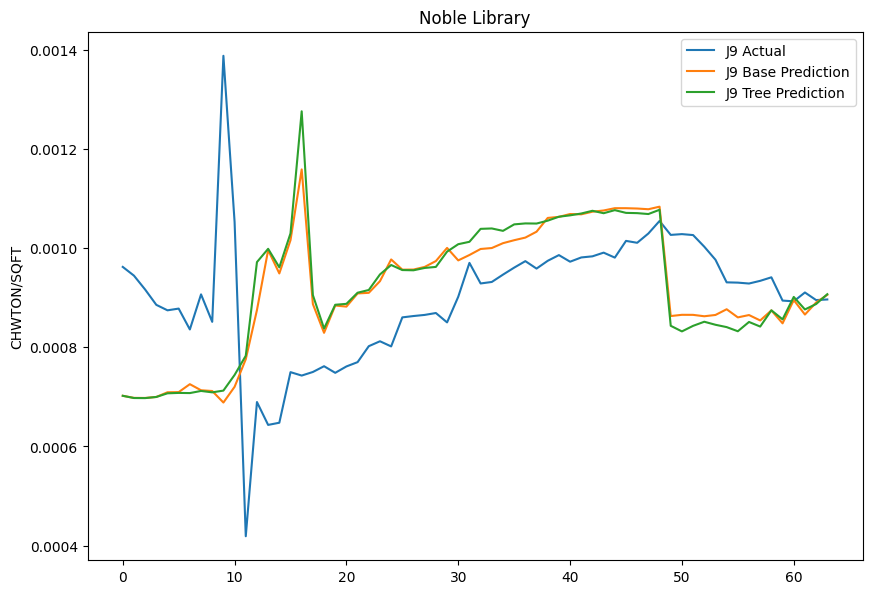

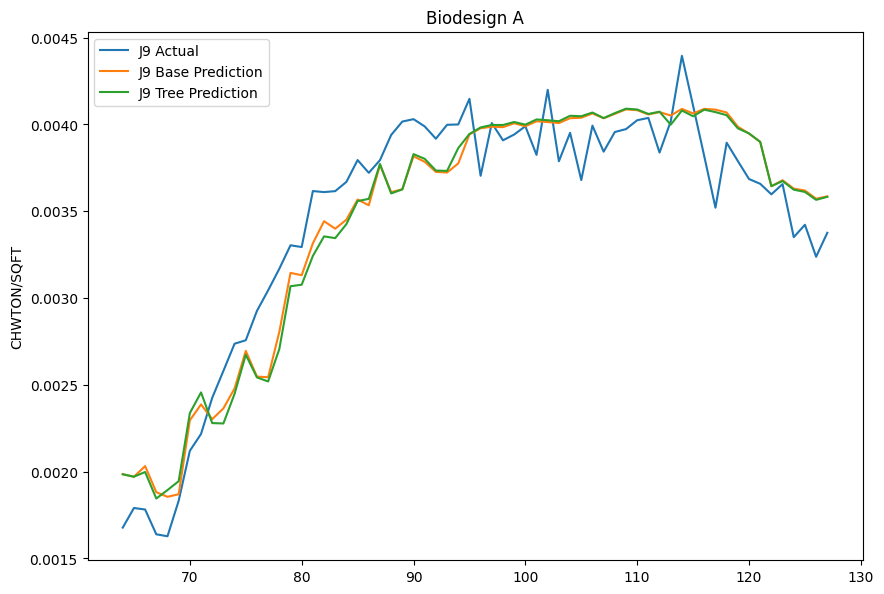

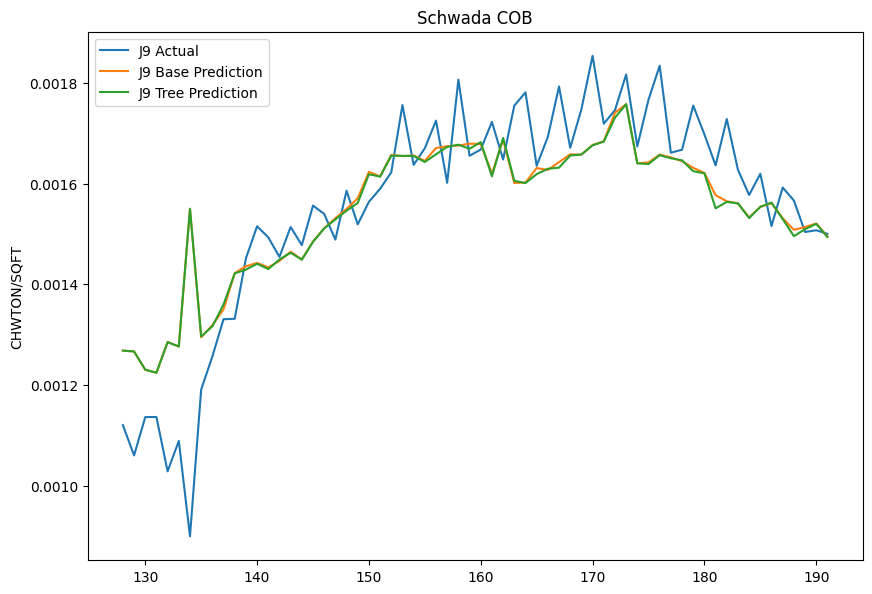

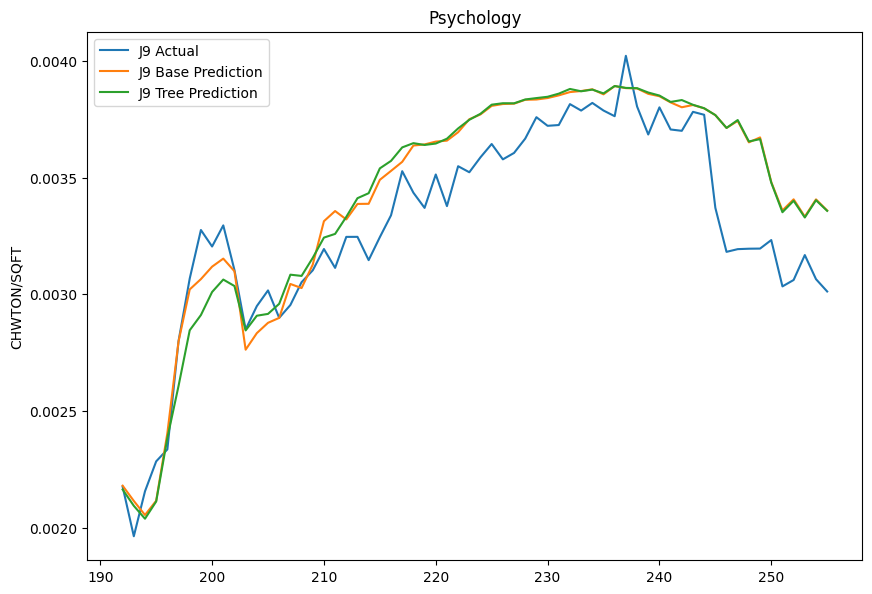

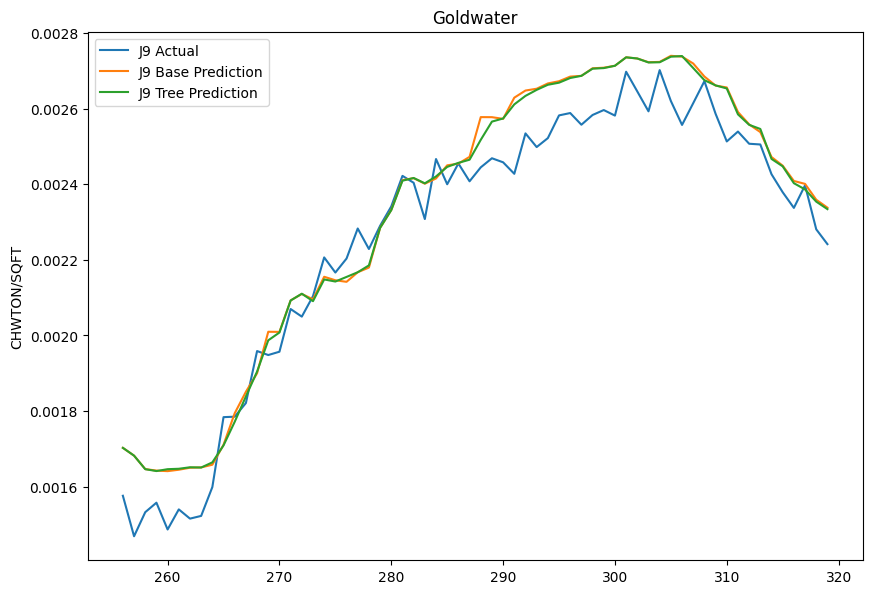

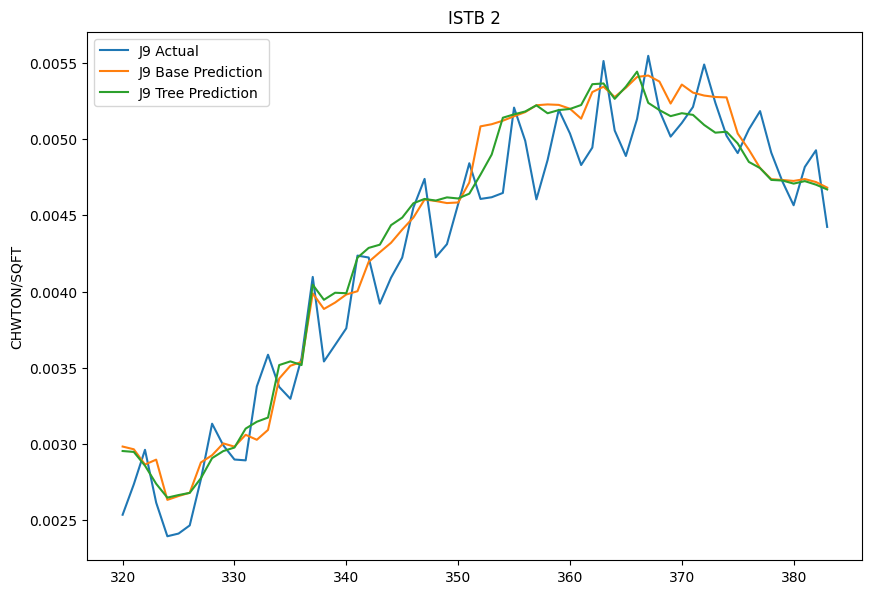

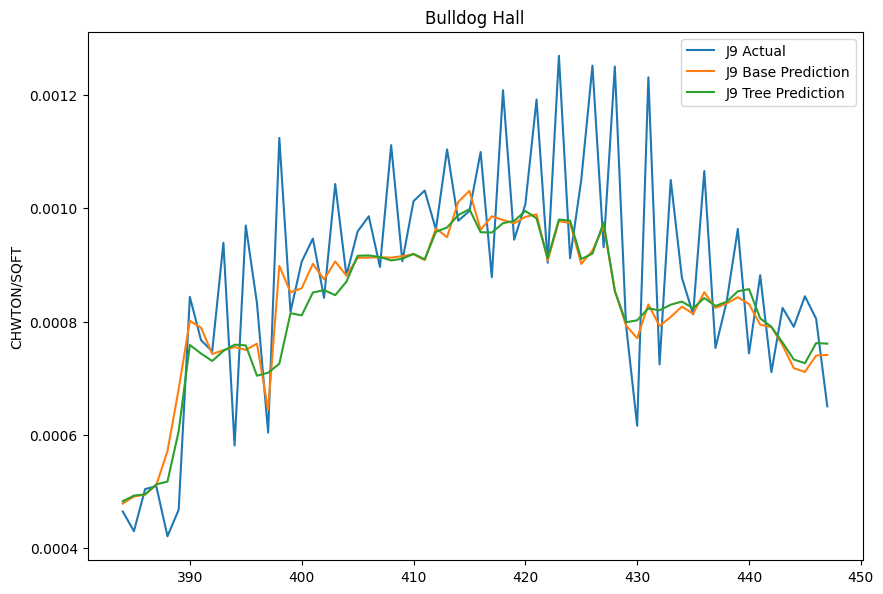

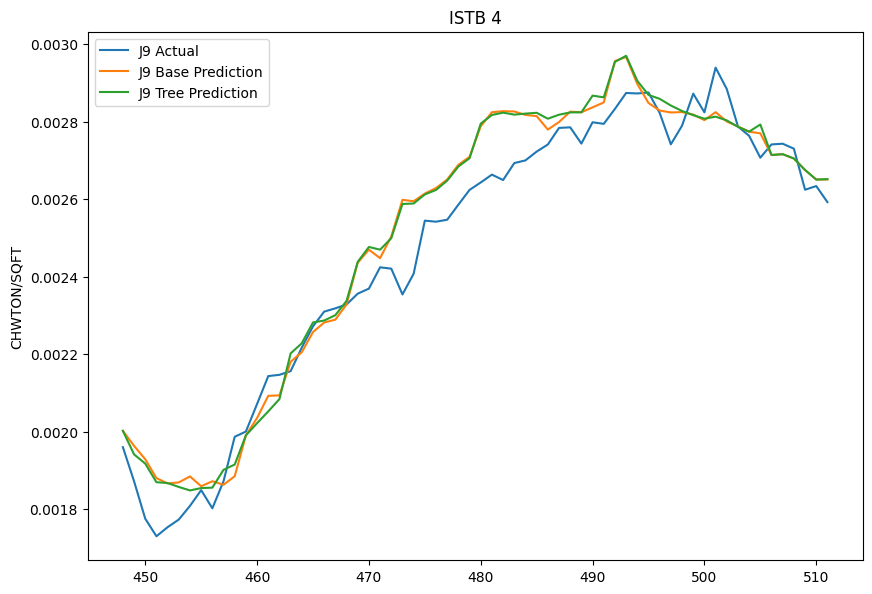

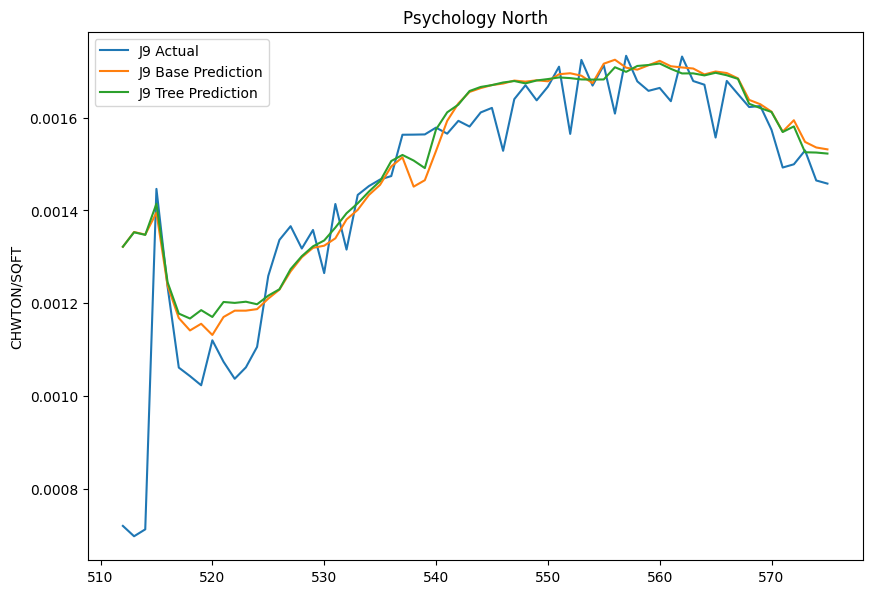

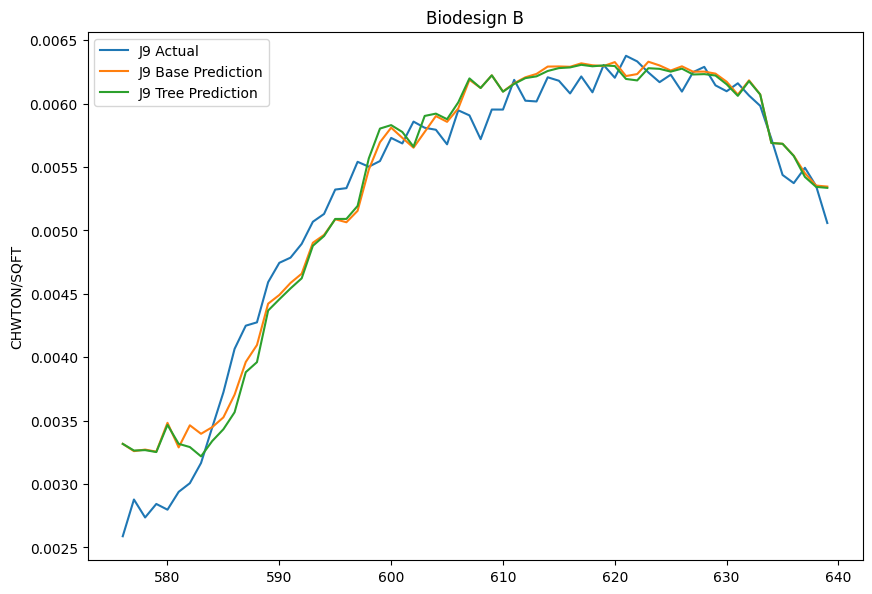

In [45]:

for i in range(len(BldgnameTest)):
    figure(figsize=(10, 7), dpi=100)
    # plt.xticks(position, BldgnameTest )
               
    single_bld = predBase[predBase['Bldgname'] == BldgnameTest[i]]   
    plt.ylabel('CHWTON/SQFT')
    plt.plot(single_bld['Act CHWTON/SQFT'], label = 'J9 Actual')
    plt.plot(single_bld['Pred CHWTON/SQFT'], label = 'J9 Base Prediction')
    plt.plot(single_bld['Tree pred CHWTON/SQFT'], label = 'J9 Tree Prediction')
    plt.legend()
    plt.title(BldgnameTest[i])           

               
               

## 5.2 Random Search Tuning

https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn

1. n_estimators:  In general the more trees the less likely the algorithm is to overfit. So try increasing this. The lower this number, the closer the model is to a decision tree, with a restricted feature set. <br>
2. max_features: try reducing this number (try 30-50% of the number of features). This determines how many features each tree is randomly assigned. The smaller, the less likely to overfit, but too small will start to introduce under fitting.<br>
3. max_depth: Experiment with this. This will reduce the complexity of the learned models, lowering over fitting risk. Try starting small, say 5-10, and increasing you get the best result. <br>
4. min_samples_leaf: Try setting this to values greater than one. This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each. <br>


In [64]:
# Define parameters for RF

# 1. Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# 2. Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# 3. Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# 4. Minimum number of samples required at each leaf node
min_samples_leaf = [ 1, 2, 4]

# 5. Method of selecting samples for training each tree
bootstrap = [True, False]

# 6. Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [65]:
# 1. Set parameters on random_RF
RF_random = RandomizedSearchCV(estimator = RF_base,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)

# 2. Train on base data
trainAndGetScore(RF_random, "RF", "random", Bldg, scores_df, Test_df)

# 3. Train on data with cyclical time features
trainAndGetScore(RF_random, "RF_cyclic", "random", Bldg_cyclic, scores_df, Test_cyclic)

scores_df

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 403, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/p

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 70, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Index(['Month', 'Day', 'Hour', 'Minute', 'DSW Top', 'DSW North', 'DSW East',
       'DSW South', 'DSW West', 'Shade North', 'Shade East', 'Shade South',
       'Shade West', 'KW', 'HTmmBTU', 'AirTempXAbsHum', 'AirTempSq',
       'AbsHumSq', 'bldgname_Biodesign B', 'bldgname_Biodesign C',
       'bldgname_Bulldog Hall', 'bldgname_Goldwater', 'bldgname_ISTB 2',
       'bldgname_ISTB 4', 'bldgname_Noble Library', 'bldgname_Psychology',
       'bldgname_Psychology North', 'bldgname_Schwada COB'],
      dtype='object')
          Bldgname  Act CHWTON/SQFT  Pred CHWTON/SQFT
0    Noble Library         0.000962          0.0006

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-pac

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 70, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Index(['DSW Top', 'DSW North', 'DSW East', 'DSW South', 'DSW West',
       'Shade North', 'Shade East', 'Shade South', 'Shade West', 'KW',
       'HTmmBTU', 'AirTempXAbsHum', 'AirTempSq', 'AbsHumSq',
       'bldgname_Biodesign B', 'bldgname_Biodesign C', 'bldgname_Bulldog Hall',
       'bldgname_Goldwater', 'bldgname_ISTB 2', 'bldgname_ISTB 4',
       'bldgname_Noble Library', 'bldgname_Psychology',
       'bldgname_Psychology North', 'bldgname_Schwada COB', 'Minute_sin',
       'Minute_cos', 'Hour_sin', 'Hour_cos', 'Day_sin', 'Day_cos', 'Month_sin',
       'Month_cos'],
      dtype='object')
          Bldgname  Act C

TestDate  modelName  randomTrain  randomValidate  randomTest
0      6 9         RF     0.998492        0.989722    0.985665
1      6 9  RF_cyclic     0.998488        0.989627    0.985356

In [66]:
print(RF_random.best_estimator_.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 70, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [67]:
# Get oob score for best random model

# 1. grab the param from best random search result
RF_best_limit_depth = RandomForestRegressor(n_estimators = 150,
                                       random_state = 42,
                                       max_depth = 7,
                                       oob_score = True,
                                       min_samples_split= 2,
                                       min_samples_leaf=1,
                                       min_weight_fraction_leaf = 0.0)

RF_best_limit_depth
# 2. split data into X and y
X = Bldg.drop(columns=['CHWTON/SQFT'])
y = Bldg['CHWTON/SQFT']  
    
X_test = Test_df.drop(columns=['CHWTON/SQFT'])
y_test = Test_df['CHWTON/SQFT']  
    
# 3. Train-Test Split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=20)
        
# 4. Fit model that already has parameters
RF_best_limit_depth.fit(X_train, y_train)
RF_best_limit_depth.oob_score_

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


0.9707891861537762

## 5.3 RF Explain Tree

In [68]:
# Get X for Explaining
BldgX = Bldg.drop(columns = 'CHWTON/SQFT')
Bldg_cyclicX = Bldg_cyclic.drop(columns = 'CHWTON/SQFT')

In [69]:
RF_best_limit_depth = RandomForestRegressor(n_estimators = 100, random_state = 42, oob_score = True, max_depth = 7)
# 1. Base RF on base data
trainAndGetScore(RF_best_limit_depth, "RF_limit_depth", "base", Bldg, scores_df, Test_df)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


Index(['Month', 'Day', 'Hour', 'Minute', 'DSW Top', 'DSW North', 'DSW East',
       'DSW South', 'DSW West', 'Shade North', 'Shade East', 'Shade South',
       'Shade West', 'KW', 'HTmmBTU', 'AirTempXAbsHum', 'AirTempSq',
       'AbsHumSq', 'bldgname_Biodesign B', 'bldgname_Biodesign C',
       'bldgname_Bulldog Hall', 'bldgname_Goldwater', 'bldgname_ISTB 2',
       'bldgname_ISTB 4', 'bldgname_Noble Library', 'bldgname_Psychology',
       'bldgname_Psychology North', 'bldgname_Schwada COB'],
      dtype='object')
          Bldgname  Act CHWTON/SQFT  Pred CHWTON/SQFT
0    Noble Library         0.000962          0.000786
1    Noble Library         0.000944          0.000783
2    Noble Library         0.000916          0.000784
3    Noble Library         0.000886          0.000775
4    Noble Library         0.000874          0.000787
..             ...              ...               ...
635    Biodesign B         0.005438          0.005690
636    Biodesign B         0.005373          0.0

Bldgname  Act CHWTON/SQFT  Pred CHWTON/SQFT
0    Noble Library         0.000962          0.000786
1    Noble Library         0.000944          0.000783
2    Noble Library         0.000916          0.000784
3    Noble Library         0.000886          0.000775
4    Noble Library         0.000874          0.000787
..             ...              ...               ...
635    Biodesign B         0.005438          0.005690
636    Biodesign B         0.005373          0.005563
637    Biodesign B         0.005494          0.005424
638    Biodesign B         0.005351          0.005368
639    Biodesign B         0.005059          0.005360

[640 rows x 3 columns]

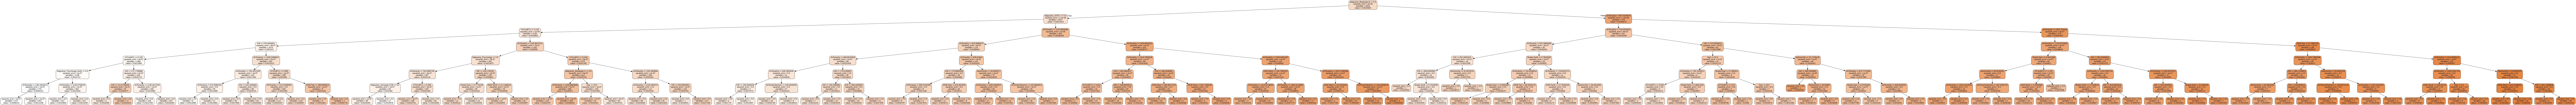

In [70]:
# 3. Extract single tree
estimator = RF_best_limit_depth.estimators_[3]

from sklearn.tree import export_graphviz

# 4. Export tree as dot file
export_graphviz(estimator,
                out_file='tree.dot', 
                feature_names = BldgX.columns,
                rounded = True,
                proportion = False, 
                precision = 7,
                filled = True)

# # 5. Convert the tree to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # 6. Display png image of this one tree in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## 5.4 RF Grid Search Tuning

In [84]:
param_grid = {'n_estimators': [150, 170],
               'max_features': ["sqrt"],
               'max_depth': [50,60,70],
               'min_samples_split': [2, 3],
               'min_samples_leaf': [ 1, 2],
               'bootstrap': bootstrap}

In [85]:
# 1. Set parameters on random_RF
RF_grid = GridSearchCV(estimator = RF_base,
                       param_grid = param_grid,
                       cv = 5,
                       scoring ='r2',
                       n_jobs = -1)

# 2. Train on base data
trainAndGetScore(RF_grid, "RF", "grid", Bldg, scores_df, Test_df)

# 3. Train on data with cyclical time features
trainAndGetScore(RF_grid, "RF_cyclic", "grid", Bldg_cyclic, scores_df, Test_cyclic)
scores_df

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 403, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 170, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Index(['Month', 'Day', 'Hour', 'Minute', 'DSW Top', 'DSW North', 'DSW East',
       'DSW South', 'DSW West', 'Shade North',
       ...
       'Date_Time_2018-07-01 18:30:00', 'Date_Time_2018-07-01 18:45:00',
       'Date_Time_2018-07-01 19:00:00', 'Date_Time_2018-07-01 19:15:00',
       'Date_Time_2018-07-01 19:30:00', 'Date_Time_2018-07-01 19:45:00',
       'Date_Time_2018-07-01 20:00:00', 'Date_Time_2018-07-01 20:15:00',
       'Date_Time_2018-07-01 20:30:00', 'Date_Time_2018-07-01 20:45:00'],
      dtype='object', length=827)
          Bldgname  Act CHWTON/SQFT  Pred CHWTON/SQFT
0    Noble Library         0.000962 

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 403, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 170, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Index(['DSW Top', 'DSW North', 'DSW East', 'DSW South', 'DSW West',
       'Shade North', 'Shade East', 'Shade South', 'Shade West', 'KW',
       ...
       'Date_Time_2018-07-01 20:30:00', 'Date_Time_2018-07-01 20:45:00',
       'Minute_sin', 'Minute_cos', 'Hour_sin', 'Hour_cos', 'Day_sin',
       'Day_cos', 'Month_sin', 'Month_cos'],
      dtype='object', length=831)
          Bldgname  Act CHWTON/SQFT  Pred CHWTON/SQFT
0    Noble Library         0.000962          0.000942
1    Noble Library         0.000944          0.001014
2    Noble Library         0.000916          0.001028
3    Noble Library         0.000886  

TestDate  modelName  gridTrain  gridValidate  gridTest
0      6 9         RF   0.995889      0.973315  0.953745
1      6 9  RF_cyclic   0.994790      0.966534  0.953602